<a href="https://colab.research.google.com/github/sabeesh90/Layer_Fine_Tuning_Deep_Neural_Networks/blob/main/The_Lazarus_Trials_VGG16_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 96 kB 3.5 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
pip install Ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
classes = ['GALAXY', 'QSO', 'STAR']

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#### VGG 16

##### Data preparation

In [ ]:
# Preprocessing the data
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 8


img_width_crop = 1024
img_height_crop = 1024

rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])


# augmenting the data
# cropless flip and rotate

data_aug_flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                # layers.experimental.preprocessing.RandomRotation(0.2)])
])

data_aug_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2)])


# crop flip and rotate
data_aug_crop_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                                 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                 layers.experimental.preprocessing.RandomRotation(0.2)])

data_aug_crop_flip = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

normal_crop = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512)],)
batch_size =32 
autotune = tf.data.AUTOTUNE

# Preparing the normal dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width_crop, img_height_crop), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width_crop, img_height_crop),
                                                                batch_size = batch_size, label_mode = 'categorical')


# preparing the scalred dataset
train_ds_scaled = train_ds.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled = val_ds.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)
train_ds.prefetch(buffer_size=autotune)
val_ds.prefetch(buffer_size=autotune)

train_ds_scaled_cropped = train_ds_scaled.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled_cropped = val_ds_scaled.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)

# augment function 
def prepare_dataset(ds, flip = False, flip_rotate = False):
    if flip == True:
        ds = ds.map(lambda x, y : (data_aug_flip(x, training = True), y), num_parallel_calls = autotune)
    elif flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)

def prepare_dataset_crop(ds, crop_flip = False, crop_flip_rotate = False):
    if crop_flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    elif crop_flip == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)
    
def prepare_dataset_normal_crop(ds, training = True):
    ds = ds.map(lambda x, y : (normal_crop(x, training = training), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
# 25 batches of 32 each and 7 batches of 32 each



Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


##### VGG16 model building

In [ ]:
from tensorflow.keras.applications import  VGG16
models = {'base_model'+str(num) : VGG16(include_top=False, weights='imagenet', 
                                           input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg') for num in range(0,14)}

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
models

{'base_model0': <keras.engine.functional.Functional at 0x7f73f026eb10>,
 'base_model1': <keras.engine.functional.Functional at 0x7f73df5bc050>,
 'base_model10': <keras.engine.functional.Functional at 0x7f73df329710>,
 'base_model11': <keras.engine.functional.Functional at 0x7f73df3140d0>,
 'base_model12': <keras.engine.functional.Functional at 0x7f73df35aa10>,
 'base_model13': <keras.engine.functional.Functional at 0x7f73df296690>,
 'base_model2': <keras.engine.functional.Functional at 0x7f73f0261050>,
 'base_model3': <keras.engine.functional.Functional at 0x7f73df541b90>,
 'base_model4': <keras.engine.functional.Functional at 0x7f73df4eeed0>,
 'base_model5': <keras.engine.functional.Functional at 0x7f73df4d1790>,
 'base_model6': <keras.engine.functional.Functional at 0x7f73df5c0550>,
 'base_model7': <keras.engine.functional.Functional at 0x7f73df3e7910>,
 'base_model8': <keras.engine.functional.Functional at 0x7f73df512dd0>,
 'base_model9': <keras.engine.functional.Functional at 0x7f7

In [ ]:
layer_count  = len(models['base_model0'].layers)
print(f'There are a total of {layer_count} in the resnet layer')

There are a total of 20 in the resnet layer


In [ ]:
for model,value in models.items():
    print(model)

base_model0
base_model1
base_model2
base_model3
base_model4
base_model5
base_model6
base_model7
base_model8
base_model9
base_model10
base_model11
base_model12
base_model13


In [ ]:
num=0
for i, (model_name, model) in zip(range(20, -1,-1), models.items()):
    break_point  = i
    for layer in model.layers[0:break_point]:
        layer.trainable = False
    for layer in model.layers[break_point:]:
        layer.trainable = True
    input_layer = model.input
    output_layer = model.output
    x = Dense(num_classes, activation  = 'softmax')(output_layer)    
    models[model_name] = Model(inputs = input_layer, outputs = x)


In [ ]:
for model_name, model in models.items():
    count = 0
    trained_layers = ['a' if layer.trainable == True else None for layer in model.layers]
    print(f'The number of trainable layers in {model_name} is', trained_layers.count('a'), sep=':')

The number of trainable layers in base_model0 is:1
The number of trainable layers in base_model1 is:2
The number of trainable layers in base_model2 is:3
The number of trainable layers in base_model3 is:4
The number of trainable layers in base_model4 is:5
The number of trainable layers in base_model5 is:6
The number of trainable layers in base_model6 is:7
The number of trainable layers in base_model7 is:8
The number of trainable layers in base_model8 is:9
The number of trainable layers in base_model9 is:10
The number of trainable layers in base_model10 is:11
The number of trainable layers in base_model11 is:12
The number of trainable layers in base_model12 is:13
The number of trainable layers in base_model13 is:14


In [ ]:
# resnet_model.summary()
for model_name, model in models.items():
    model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
i=0
for model_name, model in models.items():
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('base_model'+str(i),trainableParams,nonTrainableParams,totalParams)
    i+=1


base_model0 1539 14714688 14716227
base_model1 1539 14714688 14716227
base_model2 1539 14714688 14716227
base_model3 2361347 12354880 14716227
base_model4 4721155 9995072 14716227
base_model5 7080963 7635264 14716227
base_model6 7080963 7635264 14716227
base_model7 9440771 5275456 14716227
base_model8 11800579 2915648 14716227
base_model9 12980739 1735488 14716227
base_model10 12980739 1735488 14716227
base_model11 13570819 1145408 14716227
base_model12 14160899 555328 14716227
base_model13 14456067 260160 14716227


##### VGG16 model

In [ ]:
models['base_model0'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 281s 7s/step - loss: 1.6599 - accuracy: 0.0562 - val_loss: 1.2386 - val_accuracy: 0.0850
Epoch 2/60
25/25 [==============================] - 15s 508ms/step - loss: 1.6343 - accuracy: 0.0562 - val_loss: 1.1958 - val_accuracy: 0.0850
Epoch 3/60
25/25 [==============================] - 16s 520ms/step - loss: 1.6171 - accuracy: 0.0562 - val_loss: 1.1610 - val_accuracy: 0.0850
Epoch 4/60
25/25 [==============================] - 15s 515ms/step - loss: 1.6063 - accuracy: 0.0562 - val_loss: 1.1372 - val_accuracy: 0.0850
Epoch 5/60
25/25 [==============================] - 16s 518ms/step - loss: 1.6004 - accuracy: 0.1675 - val_loss: 1.1182 - val_accuracy: 0.3600
Epoch 6/60
25/25 [==============================] - 16s 517ms/step - loss: 1.5969 - accuracy: 0.5063 - val_loss: 1.1059 - val_accuracy: 0.4350
Epoch 7/60
25/25 [==============================] - 15s 515ms/step - loss: 1.5951 - accuracy: 0.5138 - val_loss: 1.0968 - val_accuracy: 0.4350
E

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr,early_stop])

Epoch 1/30
25/25 [==============================] - 16s 524ms/step - loss: 1.6931 - accuracy: 0.5138 - val_loss: 1.1157 - val_accuracy: 0.4350
Epoch 2/30
25/25 [==============================] - 16s 519ms/step - loss: 1.6537 - accuracy: 0.5138 - val_loss: 1.0960 - val_accuracy: 0.4350
Epoch 3/30
25/25 [==============================] - 16s 519ms/step - loss: 1.6275 - accuracy: 0.5138 - val_loss: 1.0815 - val_accuracy: 0.4350
Epoch 4/30
25/25 [==============================] - 16s 522ms/step - loss: 1.6110 - accuracy: 0.5138 - val_loss: 1.0714 - val_accuracy: 0.4350
Epoch 5/30
25/25 [==============================] - 15s 515ms/step - loss: 1.6000 - accuracy: 0.5138 - val_loss: 1.0655 - val_accuracy: 0.4350
Epoch 6/30
25/25 [==============================] - 16s 527ms/step - loss: 1.5945 - accuracy: 0.5138 - val_loss: 1.0635 - val_accuracy: 0.4350
Epoch 7/30
25/25 [==============================] - 15s 514ms/step - loss: 1.5903 - accuracy: 0.5138 - val_loss: 1.0635 - val_accuracy: 0.4350

In [ ]:
models['base_model2'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 16s 516ms/step - loss: 1.7976 - accuracy: 0.4300 - val_loss: 0.9578 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 15s 516ms/step - loss: 1.7492 - accuracy: 0.4300 - val_loss: 0.9548 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 15s 511ms/step - loss: 1.7104 - accuracy: 0.4300 - val_loss: 0.9575 - val_accuracy: 0.4800
Epoch 4/60
25/25 [==============================] - 16s 518ms/step - loss: 1.6820 - accuracy: 0.4300 - val_loss: 0.9666 - val_accuracy: 0.4800
Epoch 5/60
25/25 [==============================] - 15s 517ms/step - loss: 1.6570 - accuracy: 0.4300 - val_loss: 0.9754 - val_accuracy: 0.4800
Epoch 6/60
25/25 [==============================] - 16s 518ms/step - loss: 1.6387 - accuracy: 0.4300 - val_loss: 0.9849 - val_accuracy: 0.4800
Epoch 7/60
25/25 [==============================] - 16s 525ms/step - loss: 1.6254 - accuracy: 0.4300 - val_loss: 0.9960 - val_accuracy: 0.4800

In [ ]:
models['base_model3'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 16s 500ms/step - loss: 1.7123 - accuracy: 0.4363 - val_loss: 1.0927 - val_accuracy: 0.3800
Epoch 2/60
25/25 [==============================] - 16s 527ms/step - loss: 1.5720 - accuracy: 0.4675 - val_loss: 1.0847 - val_accuracy: 0.3900
Epoch 3/60
25/25 [==============================] - 16s 532ms/step - loss: 1.5400 - accuracy: 0.5425 - val_loss: 1.0290 - val_accuracy: 0.5200
Epoch 4/60
25/25 [==============================] - 16s 526ms/step - loss: 1.5004 - accuracy: 0.6450 - val_loss: 1.0475 - val_accuracy: 0.3400
Epoch 5/60
25/25 [==============================] - 16s 521ms/step - loss: 1.4707 - accuracy: 0.4700 - val_loss: 0.9268 - val_accuracy: 0.6450
Epoch 6/60
25/25 [==============================] - 16s 520ms/step - loss: 1.4361 - accuracy: 0.5800 - val_loss: 0.9707 - val_accuracy: 0.6050
Epoch 7/60
25/25 [==============================] - 16s 520ms/step - loss: 1.4107 - accuracy: 0.6050 - val_loss: 0.9410 - val_accuracy: 0.6500

In [ ]:
models['base_model4'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 17s 528ms/step - loss: 1.6359 - accuracy: 0.4125 - val_loss: 1.1156 - val_accuracy: 0.1550
Epoch 2/60
25/25 [==============================] - 16s 524ms/step - loss: 1.5246 - accuracy: 0.4075 - val_loss: 0.9150 - val_accuracy: 0.7300
Epoch 3/60
25/25 [==============================] - 16s 525ms/step - loss: 1.3476 - accuracy: 0.7175 - val_loss: 0.8538 - val_accuracy: 0.6650
Epoch 4/60
25/25 [==============================] - 16s 538ms/step - loss: 1.2685 - accuracy: 0.7000 - val_loss: 0.8972 - val_accuracy: 0.5450
Epoch 5/60
25/25 [==============================] - 16s 529ms/step - loss: 1.1989 - accuracy: 0.7013 - val_loss: 0.7243 - val_accuracy: 0.6950
Epoch 6/60
25/25 [==============================] - 16s 524ms/step - loss: 1.1180 - accuracy: 0.7513 - val_loss: 0.6836 - val_accuracy: 0.6800
Epoch 7/60
25/25 [==============================] - 16s 532ms/step - loss: 1.0468 - accuracy: 0.7287 - val_loss: 0.6789 - val_accuracy: 0.6600

In [ ]:
models['base_model5'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 16s 533ms/step - loss: 1.6103 - accuracy: 0.5013 - val_loss: 1.0344 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 16s 535ms/step - loss: 1.3909 - accuracy: 0.6187 - val_loss: 0.7556 - val_accuracy: 0.7150
Epoch 3/60
25/25 [==============================] - 16s 539ms/step - loss: 1.1831 - accuracy: 0.6975 - val_loss: 0.8242 - val_accuracy: 0.6500
Epoch 4/60
25/25 [==============================] - 16s 532ms/step - loss: 1.1723 - accuracy: 0.7425 - val_loss: 0.8846 - val_accuracy: 0.5500
Epoch 5/60
25/25 [==============================] - 16s 534ms/step - loss: 1.0455 - accuracy: 0.7475 - val_loss: 0.5905 - val_accuracy: 0.6850
Epoch 6/60
25/25 [==============================] - 16s 528ms/step - loss: 0.9340 - accuracy: 0.7362 - val_loss: 0.7975 - val_accuracy: 0.5550
Epoch 7/60
25/25 [==============================] - 16s 532ms/step - loss: 0.9219 - accuracy: 0.7175 - val_loss: 0.5279 - val_accuracy: 0.6850

In [ ]:
models['base_model6'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 17s 544ms/step - loss: 1.6055 - accuracy: 0.4688 - val_loss: 1.0565 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 16s 537ms/step - loss: 1.3837 - accuracy: 0.7063 - val_loss: 0.8402 - val_accuracy: 0.6050
Epoch 3/60
25/25 [==============================] - 16s 533ms/step - loss: 1.2378 - accuracy: 0.7362 - val_loss: 0.9931 - val_accuracy: 0.4700
Epoch 4/60
25/25 [==============================] - 16s 535ms/step - loss: 1.1043 - accuracy: 0.7450 - val_loss: 0.5648 - val_accuracy: 0.7850
Epoch 5/60
25/25 [==============================] - 16s 535ms/step - loss: 1.0419 - accuracy: 0.7425 - val_loss: 0.6043 - val_accuracy: 0.8450
Epoch 6/60
25/25 [==============================] - 16s 538ms/step - loss: 0.9775 - accuracy: 0.7850 - val_loss: 0.4883 - val_accuracy: 0.8150
Epoch 7/60
25/25 [==============================] - 16s 534ms/step - loss: 0.8728 - accuracy: 0.7912 - val_loss: 0.5020 - val_accuracy: 0.7550

In [ ]:
models['base_model7'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 17s 542ms/step - loss: 1.6619 - accuracy: 0.4400 - val_loss: 1.0015 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 16s 545ms/step - loss: 1.4273 - accuracy: 0.6363 - val_loss: 0.8512 - val_accuracy: 0.6550
Epoch 3/60
25/25 [==============================] - 16s 548ms/step - loss: 1.2506 - accuracy: 0.7312 - val_loss: 0.7331 - val_accuracy: 0.7750
Epoch 4/60
25/25 [==============================] - 16s 550ms/step - loss: 1.1170 - accuracy: 0.7525 - val_loss: 0.6347 - val_accuracy: 0.7550
Epoch 5/60
25/25 [==============================] - 16s 547ms/step - loss: 0.9769 - accuracy: 0.7088 - val_loss: 0.5169 - val_accuracy: 0.8550
Epoch 6/60
25/25 [==============================] - 16s 549ms/step - loss: 0.9768 - accuracy: 0.7538 - val_loss: 0.5544 - val_accuracy: 0.8300
Epoch 7/60
25/25 [==============================] - 16s 551ms/step - loss: 0.8985 - accuracy: 0.7600 - val_loss: 0.5038 - val_accuracy: 0.8400

In [ ]:
models['base_model8'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 18s 592ms/step - loss: 1.5318 - accuracy: 0.5213 - val_loss: 0.9100 - val_accuracy: 0.5500
Epoch 2/60
25/25 [==============================] - 17s 586ms/step - loss: 1.4291 - accuracy: 0.5738 - val_loss: 1.0376 - val_accuracy: 0.5000
Epoch 3/60
25/25 [==============================] - 17s 582ms/step - loss: 1.2187 - accuracy: 0.7100 - val_loss: 0.8373 - val_accuracy: 0.5100
Epoch 4/60
25/25 [==============================] - 17s 584ms/step - loss: 1.1801 - accuracy: 0.6587 - val_loss: 0.9279 - val_accuracy: 0.5100
Epoch 5/60
25/25 [==============================] - 17s 581ms/step - loss: 1.0937 - accuracy: 0.7225 - val_loss: 0.6371 - val_accuracy: 0.8000
Epoch 6/60
25/25 [==============================] - 17s 584ms/step - loss: 0.9897 - accuracy: 0.6875 - val_loss: 0.7139 - val_accuracy: 0.5850
Epoch 7/60
25/25 [==============================] - 17s 591ms/step - loss: 0.8548 - accuracy: 0.7937 - val_loss: 0.4978 - val_accuracy: 0.8050

In [ ]:
models['base_model9'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 19s 625ms/step - loss: 1.6316 - accuracy: 0.4787 - val_loss: 1.0356 - val_accuracy: 0.4500
Epoch 2/60
25/25 [==============================] - 18s 619ms/step - loss: 1.4592 - accuracy: 0.6650 - val_loss: 0.8582 - val_accuracy: 0.4950
Epoch 3/60
25/25 [==============================] - 18s 619ms/step - loss: 1.2630 - accuracy: 0.7262 - val_loss: 0.7067 - val_accuracy: 0.7350
Epoch 4/60
25/25 [==============================] - 18s 619ms/step - loss: 1.1201 - accuracy: 0.6562 - val_loss: 0.7098 - val_accuracy: 0.7950
Epoch 5/60
25/25 [==============================] - 18s 619ms/step - loss: 1.0246 - accuracy: 0.7750 - val_loss: 0.5927 - val_accuracy: 0.7950
Epoch 6/60
25/25 [==============================] - 18s 621ms/step - loss: 1.0212 - accuracy: 0.7462 - val_loss: 0.4879 - val_accuracy: 0.8350
Epoch 7/60
25/25 [==============================] - 18s 621ms/step - loss: 0.9675 - accuracy: 0.7900 - val_loss: 0.7176 - val_accuracy: 0.7050

In [ ]:
models['base_model10'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 19s 631ms/step - loss: 1.6849 - accuracy: 0.3862 - val_loss: 1.0616 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 18s 621ms/step - loss: 1.6184 - accuracy: 0.4475 - val_loss: 1.0559 - val_accuracy: 0.4350
Epoch 3/60
25/25 [==============================] - 18s 617ms/step - loss: 1.5288 - accuracy: 0.5425 - val_loss: 0.9263 - val_accuracy: 0.6800
Epoch 4/60
25/25 [==============================] - 18s 621ms/step - loss: 1.2901 - accuracy: 0.6438 - val_loss: 0.6960 - val_accuracy: 0.7900
Epoch 5/60
25/25 [==============================] - 18s 619ms/step - loss: 1.1723 - accuracy: 0.6925 - val_loss: 0.6468 - val_accuracy: 0.8250
Epoch 6/60
25/25 [==============================] - 18s 621ms/step - loss: 1.0221 - accuracy: 0.7375 - val_loss: 0.6162 - val_accuracy: 0.6300
Epoch 7/60
25/25 [==============================] - 18s 623ms/step - loss: 0.9441 - accuracy: 0.7563 - val_loss: 0.6536 - val_accuracy: 0.6900

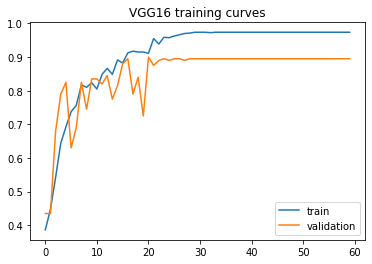

In [ ]:
plt.plot(models['base_model10'].history.history['accuracy'])
plt.plot(models['base_model10'].history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('VGG16 training curves')
plt.show()

In [ ]:
models['base_model10'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 19s 622ms/step - loss: 1.5500 - accuracy: 0.5688 - val_loss: 0.9697 - val_accuracy: 0.5900
Epoch 2/60
25/25 [==============================] - 18s 616ms/step - loss: 1.3251 - accuracy: 0.6463 - val_loss: 0.7007 - val_accuracy: 0.7850
Epoch 3/60
25/25 [==============================] - 18s 617ms/step - loss: 1.1047 - accuracy: 0.7050 - val_loss: 0.6282 - val_accuracy: 0.7150
Epoch 4/60
25/25 [==============================] - 18s 617ms/step - loss: 0.9893 - accuracy: 0.7613 - val_loss: 0.7398 - val_accuracy: 0.7850
Epoch 5/60
25/25 [==============================] - 18s 620ms/step - loss: 0.8766 - accuracy: 0.7987 - val_loss: 0.6817 - val_accuracy: 0.7600
Epoch 6/60
25/25 [==============================] - 18s 620ms/step - loss: 0.9226 - accuracy: 0.8062 - val_loss: 0.6842 - val_accuracy: 0.6850
Epoch 7/60
25/25 [==============================] - 18s 617ms/step - loss: 0.7045 - accuracy: 0.8350 - val_loss: 0.4380 - val_accuracy: 0.8600

In [ ]:
models['base_model11'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 21s 673ms/step - loss: 1.6790 - accuracy: 0.4075 - val_loss: 1.0376 - val_accuracy: 0.4400
Epoch 2/60
25/25 [==============================] - 19s 671ms/step - loss: 1.5858 - accuracy: 0.5437 - val_loss: 0.9788 - val_accuracy: 0.8050
Epoch 3/60
25/25 [==============================] - 19s 669ms/step - loss: 1.3689 - accuracy: 0.6850 - val_loss: 0.7702 - val_accuracy: 0.8100
Epoch 4/60
25/25 [==============================] - 19s 666ms/step - loss: 1.2037 - accuracy: 0.7412 - val_loss: 0.8005 - val_accuracy: 0.5200
Epoch 5/60
25/25 [==============================] - 20s 674ms/step - loss: 1.1931 - accuracy: 0.6750 - val_loss: 0.7139 - val_accuracy: 0.7950
Epoch 6/60
25/25 [==============================] - 19s 667ms/step - loss: 1.1260 - accuracy: 0.6950 - val_loss: 0.8618 - val_accuracy: 0.4850
Epoch 7/60
25/25 [==============================] - 19s 667ms/step - loss: 1.0908 - accuracy: 0.7013 - val_loss: 0.6637 - val_accuracy: 0.5400

In [ ]:
models['base_model12'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 22s 736ms/step - loss: 1.6249 - accuracy: 0.3700 - val_loss: 1.0266 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 21s 724ms/step - loss: 1.5268 - accuracy: 0.5950 - val_loss: 0.9628 - val_accuracy: 0.5200
Epoch 3/60
25/25 [==============================] - 21s 724ms/step - loss: 1.3475 - accuracy: 0.6550 - val_loss: 0.7684 - val_accuracy: 0.5300
Epoch 4/60
25/25 [==============================] - 21s 724ms/step - loss: 1.1143 - accuracy: 0.7250 - val_loss: 0.7473 - val_accuracy: 0.7600
Epoch 5/60
25/25 [==============================] - 21s 724ms/step - loss: 0.9443 - accuracy: 0.7450 - val_loss: 0.6190 - val_accuracy: 0.7050
Epoch 6/60
25/25 [==============================] - 21s 725ms/step - loss: 1.1428 - accuracy: 0.7550 - val_loss: 0.6198 - val_accuracy: 0.8350
Epoch 7/60
25/25 [==============================] - 21s 721ms/step - loss: 0.8404 - accuracy: 0.8062 - val_loss: 0.5830 - val_accuracy: 0.7500

In [ ]:
models['base_model13'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 23s 784ms/step - loss: 1.6446 - accuracy: 0.4200 - val_loss: 1.0037 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 22s 775ms/step - loss: 1.6247 - accuracy: 0.3462 - val_loss: 1.0340 - val_accuracy: 0.4350
Epoch 3/60
25/25 [==============================] - 22s 775ms/step - loss: 1.5679 - accuracy: 0.3800 - val_loss: 0.8875 - val_accuracy: 0.4350
Epoch 4/60
25/25 [==============================] - 22s 774ms/step - loss: 1.4584 - accuracy: 0.5625 - val_loss: 0.9004 - val_accuracy: 0.7150
Epoch 5/60
25/25 [==============================] - 22s 771ms/step - loss: 1.2283 - accuracy: 0.7437 - val_loss: 0.7994 - val_accuracy: 0.5000
Epoch 6/60
25/25 [==============================] - 22s 776ms/step - loss: 1.1076 - accuracy: 0.7237 - val_loss: 0.6545 - val_accuracy: 0.7900
Epoch 7/60
25/25 [==============================] - 22s 778ms/step - loss: 1.1057 - accuracy: 0.6975 - val_loss: 0.6124 - val_accuracy: 0.8100

In [ ]:
from tensorflow.keras.applications import  VGG16
base_vgg= VGG16(include_top=False, weights='imagenet',input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg')
for layer in base_vgg.layers:
    layer.trainable = True
input_layer = base_vgg.input
output_layer = base_vgg.output
x = Dense(num_classes, activation  = 'softmax')(output_layer)    
base_vgg_retrained = Model(inputs = input_layer, outputs = x)

trained_layers = ['a' if layer.trainable == True else None for layer in base_vgg_retrained.layers]
print(f'The number of trainable layers in base_vgg_retrained is', trained_layers.count('a'), sep=':')

58900480/58889256 [==============================] - 0s 0us/step
The number of trainable layers in base_vgg_retrained is:21


In [ ]:
base_vgg_retrained.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
base_vgg_retrained.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 294s 8s/step - loss: 1.6727 - accuracy: 0.3537 - val_loss: 1.0505 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 33s 1s/step - loss: 1.4184 - accuracy: 0.6438 - val_loss: 0.8920 - val_accuracy: 0.5100
Epoch 3/60
25/25 [==============================] - 34s 1s/step - loss: 1.2011 - accuracy: 0.7437 - val_loss: 0.8939 - val_accuracy: 0.7200
Epoch 4/60
25/25 [==============================] - 34s 1s/step - loss: 1.1094 - accuracy: 0.7212 - val_loss: 0.7706 - val_accuracy: 0.7700
Epoch 5/60
25/25 [==============================] - 34s 1s/step - loss: 1.1971 - accuracy: 0.6150 - val_loss: 0.6998 - val_accuracy: 0.5750
Epoch 6/60
25/25 [==============================] - 34s 1s/step - loss: 1.0702 - accuracy: 0.6737 - val_loss: 0.6233 - val_accuracy: 0.8500
Epoch 7/60
25/25 [==============================] - 34s 1s/step - loss: 0.9791 - accuracy: 0.7613 - val_loss: 0.6184 - val_accuracy: 0.8000
Epoch 8/60
25/25 [=